In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


## Note: about 15min to run

## Read data

In [2]:
train = pd.read_csv('collision_train_data.csv')
test = pd.read_csv('collision_test_data.csv')

## Convert y class

- 0: Property Damage Crash

- 1: Injury Crash

- 2: Fatal Crash

In [3]:
target_mapping = {
    'Property Damage Crash': 0,
    'Injury Crash': 1,
    'Fatal Crash': 2
}
train['ACRS Report Type'] = train['ACRS Report Type'].map(target_mapping)
test['ACRS Report Type'] = test['ACRS Report Type'].map(target_mapping)

## Convert all categorical columns to numeric

In [4]:
categorical_columns = train.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_columns:
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.fit_transform(test[col].astype(str))

## Apply SMOTE

In [5]:
X = train.drop('ACRS Report Type', axis=1)
y = train['ACRS Report Type']
X_test = test.drop('ACRS Report Type', axis=1)
y_test = test['ACRS Report Type']

print("Before SMOTE:", Counter(y))

# Apply SMOTE to balance the dataset
smote = SMOTE(k_neighbors=5, random_state=1)
X_train, y_train = smote.fit_resample(X, y)

# Check class distribution after applying SMOTE
print("After SMOTE:", Counter(y_train))

Before SMOTE: Counter({0: 44993, 1: 29648, 2: 215})
After SMOTE: Counter({0: 44993, 1: 44993, 2: 44993})


In [6]:
Counter(y_train), Counter(y_test)

(Counter({0: 44993, 1: 44993, 2: 44993}), Counter({0: 19283, 1: 12707, 2: 92}))

## Apply AdaBoost

### Find best parameters

Coarse Search

In [7]:
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=22), random_state=22)
coarse_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.5],
    'estimator__max_depth': [1, 2, 3]
}

coarse_grid_search = GridSearchCV(estimator=adaboost, param_grid=coarse_param_grid, cv=3, scoring='recall_macro', verbose=2, n_jobs=-1)
coarse_grid_search.fit(X_train, y_train)

coarse_results_df = pd.DataFrame(coarse_grid_search.cv_results_)

coarse_results_summary = coarse_results_df[['param_n_estimators', 'param_learning_rate', 'param_estimator__max_depth', 'mean_test_score', 'std_test_score']]
coarse_results_summary = coarse_results_summary.sort_values(by='mean_test_score', ascending=False)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=50; total time=   4.5s
[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=50; total time=   4.5s
[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=50; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=50; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=50; total time=   4.7s
[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=50; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=100; total time=   8.5s
[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=100; total time=   8.6s
[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=100; total time=   8.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=100; total time=   8.7s
[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=100; total time=   8.8s
[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=50; total time=   4.5s
[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=50; total time=   4.7s
[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=50; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=100; total time=  10.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=200; total time=  18.4s
[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=200; total time=  18.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.05, n_estimators=200; total time=  19.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=100; total time=   9.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=100; total time=   9.7s
[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=100; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=200; total time=  18.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=200; total time=  20.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=200; total time=  20.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=50; total time=   8.9s
[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=50; total time=   8.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=50; total time=   8.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=200; total time=  19.2s
[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=200; total time=  19.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=1, learning_rate=0.5, n_estimators=200; total time=  18.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=50; total time=   8.6s
[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=50; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=50; total time=   8.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=100; total time=  16.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=100; total time=  17.4s
[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=100; total time=  17.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=50; total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=50; total time=   8.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=50; total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=100; total time=  17.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=100; total time=  17.1s
[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=100; total time=  16.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=200; total time=  34.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=200; total time=  32.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.05, n_estimators=200; total time=  34.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=100; total time=  16.6s
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=100; total time=  17.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=100; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=200; total time=  33.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=200; total time=  34.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.1, n_estimators=200; total time=  34.4s
[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=50; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=50; total time=  12.2s
[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=50; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=200; total time=  32.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=50; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=50; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=200; total time=  34.3s
[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=50; total time=  12.5s
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=200; total time=  34.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=100; total time=  23.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=100; total time=  24.8s
[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=100; total time=  24.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=50; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=50; total time=  11.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=50; total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=100; total time=  23.4s
[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=100; total time=  24.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=100; total time=  24.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=200; total time=  47.3s
[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=200; total time=  48.8s
[CV] END estimator__max_depth=3, learning_rate=0.05, n_estimators=200; total time=  49.2s
[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=100; total time=  22.9s
[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=100; total time=  22.2s
[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=100; total time=  22.9s
[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=200; total time=  44.1s
[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=200; total time=  45.6s
[CV] END estimator__max_depth=3, learning_rate=0.1, n_estimators=200; total time=  45.7s
[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=200; total time=  37.6s
[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=200; total time=  39.0s
[CV] END estimator

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [8]:
print("Best Parameters:", coarse_grid_search.best_params_)
print("Best Accuracy:", coarse_grid_search.best_score_)
coarse_results_summary.head(10)

Best Parameters: {'estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 200}
Best Accuracy: 0.6777320121040206


,param_n_estimators,param_learning_rate,param_estimator__max_depth,mean_test_score,std_test_score
26,200,0.50,3,0.677732,0.050933
17,200,0.50,2,0.668501,0.038712
25,100,0.50,3,0.667901,0.045135
23,200,0.10,3,0.657285,0.028989
24,50,0.50,3,0.649646,0.021881
16,100,0.50,2,0.645253,0.024935
20,200,0.05,3,0.637763,0.022309
14,200,0.10,2,0.632288,0.020962
22,100,0.10,3,0.631925,0.022420
8,200,0.50,1,0.628186,0.014250


### Refine Search 

In [9]:
coarse_best_params = coarse_grid_search.best_params_
refined_param_grid = {
    'n_estimators': [coarse_best_params['n_estimators'] - 50, coarse_best_params['n_estimators'], coarse_best_params['n_estimators'] + 50],
    'learning_rate': [max(0.01, coarse_best_params['learning_rate'] - 0.05), coarse_best_params['learning_rate'], coarse_best_params['learning_rate'] + 0.05],
    'estimator__max_depth': [max(1, coarse_best_params['estimator__max_depth'] - 1), coarse_best_params['estimator__max_depth'], coarse_best_params['estimator__max_depth'] + 1]
}

refined_grid_search = GridSearchCV(estimator=adaboost, param_grid=refined_param_grid, cv=3, scoring='recall_macro', verbose=2, n_jobs=-1)
refined_grid_search.fit(X_train, y_train)

fine_results_df = pd.DataFrame(refined_grid_search.cv_results_)

fine_results_summary = fine_results_df[['param_n_estimators', 'param_learning_rate', 'param_estimator__max_depth', 'mean_test_score', 'std_test_score']]
fine_results_summary = fine_results_summary.sort_values(by='mean_test_score', ascending=False)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=  23.4s
[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=150; total time=  23.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=  24.3s
[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=150; total time=  24.3s
[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=150; total time=  24.4s
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=  24.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=200; total time=  31.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=200; total time=  32.5s
[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=200; total time=  32.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=250; total time=  39.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=250; total time=  40.6s
[CV] END estimator__max_depth=2, learning_rate=0.45, n_estimators=250; total time=  40.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=200; total time=  31.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=150; total time=  24.6s
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=200; total time=  32.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=200; total time=  32.6s
[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=150; total time=  23.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=150; total time=  24.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=250; total time=  39.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=250; total time=  40.5s
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=250; total time=  40.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=200; total time=  32.8s
[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=200; total time=  31.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=200; total time=  32.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=150; total time=  34.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=150; total time=  35.9s
[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=150; total time=  36.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=250; total time=  39.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=250; total time=  41.6s
[CV] END estimator__max_depth=2, learning_rate=0.55, n_estimators=250; total time=  41.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=200; total time=  46.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=200; total time=  47.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=200; total time=  47.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=150; total time=  34.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=150; total time=  35.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=150; total time=  35.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=250; total time=  57.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=250; total time=  60.0s
[CV] END estimator__max_depth=3, learning_rate=0.45, n_estimators=250; total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=200; total time=  45.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=200; total time=  47.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=200; total time=  47.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=150; total time=  34.3s
[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=150; total time=  35.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=150; total time=  35.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=250; total time=  56.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=250; total time=  59.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.5, n_estimators=250; total time=  59.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=200; total time=  45.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=200; total time=  47.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=200; total time=  47.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=250; total time=  56.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=250; total time=  59.0s
[CV] END estimator__max_depth=3, learning_rate=0.55, n_estimators=250; total time=  59.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=150; total time=  44.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=150; total time=  46.9s
[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=150; total time=  46.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=200; total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=200; total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=200; total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=150; total time=  46.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=150; total time=  48.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=150; total time=  48.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=250; total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=250; total time= 1.3min
[CV] END estimator__max_depth=4, learning_rate=0.45, n_estimators=250; total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=200; total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=200; total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=200; total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=150; total time=  46.2s
[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=150; total time=  48.2s
[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=150; total time=  47.9s
[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=250; total time= 1.2min
[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=250; total time= 1.3min
[CV] END estimator__max_depth=4, learning_rate=0.5, n_estimators=250; total time= 1.3min
[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=200; total time=  56.5s
[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=200; total time=  58.8s
[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=200; total time=  58.6s
[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=250; total time= 1.0min
[CV] END estimator__max_depth=4, learning_rate=0.55, n_estimators=250; total time= 1.1min
[CV] END esti

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [10]:
print("Best Parameters:", refined_grid_search.best_params_)
print("Best Accuracy:", refined_grid_search.best_score_)

fine_results_summary.head(10)

Best Parameters: {'estimator__max_depth': 4, 'learning_rate': 0.55, 'n_estimators': 250}
Best Accuracy: 0.6967578863942667


,param_n_estimators,param_learning_rate,param_estimator__max_depth,mean_test_score,std_test_score
26,250,0.55,4,0.696758,0.059046
20,250,0.45,4,0.692246,0.061518
23,250,0.50,4,0.690920,0.057915
25,200,0.55,4,0.689742,0.060397
22,200,0.50,4,0.688852,0.058677
21,150,0.50,4,0.687941,0.064050
19,200,0.45,4,0.687193,0.066856
18,150,0.45,4,0.686874,0.056506
17,250,0.55,3,0.686326,0.059714
16,200,0.55,3,0.685978,0.061095


## Evaluation

In [11]:
def multi_eval(model, X_test, y_test, y_pred, average='weighted'):
    if average not in ['weighted', 'macro', 'micro']:
        raise ValueError("average should be in 'weighted', 'macro', 'micro'")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    # Calculate ROC-AUC score
    # Binarize the true labels
    classes = sorted(set(y_test))
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_pred_proba = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')

    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
        "Value": [accuracy, precision, recall, f1, roc_auc]
    })
    return metrics_df
    

In [12]:
best_adaboost = refined_grid_search.best_estimator_
y_pred = best_adaboost.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Property Damage Crash', 'Injury Crash', 'Fatal Crash']))

                       precision    recall  f1-score   support

Property Damage Crash       0.63      0.61      0.62     19283
         Injury Crash       0.43      0.46      0.45     12707
          Fatal Crash       0.47      0.09      0.15        92

             accuracy                           0.55     32082
            macro avg       0.51      0.39      0.40     32082
         weighted avg       0.55      0.55      0.55     32082



In [13]:
print(multi_eval(best_adaboost, X_test, y_test, y_pred))

      Metric     Value
0   Accuracy  0.547503
1  Precision  0.552177
2     Recall  0.547503
3   F1-Score  0.549139
4    ROC-AUC  0.588820


### confusion matrix

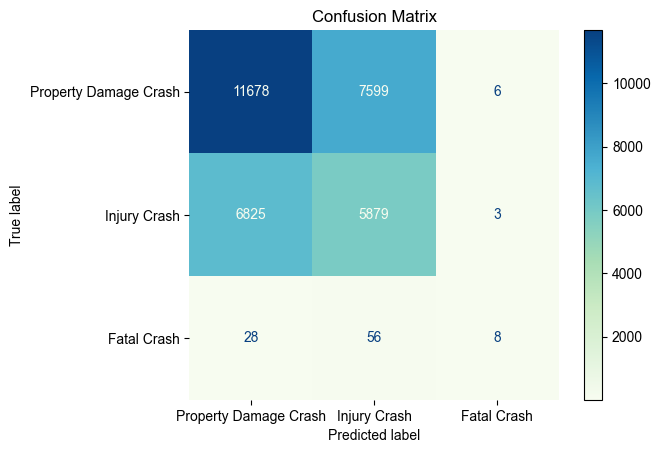

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Property Damage Crash', 'Injury Crash', 'Fatal Crash'])
disp.plot(cmap='GnBu', values_format='d')
sns.despine(left=True, bottom=True)
sns.set_style('dark')
plt.title("Confusion Matrix")
plt.show()

## XGBoost

In [15]:
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=666
)

param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10)
}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=20, 
                                   scoring='recall_macro', cv=5, verbose=1, random_state=666)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
# Best Parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.20333333333333334}
# Best Score: 0.8358455278711292

best_xgb_model = random_search.best_estimator_ 
y_pred_xgb = best_xgb_model.predict(X_test)                                  

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:07:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:07:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:07:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src

Best Parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.20333333333333334}
Best Score: 0.8358455278711292


In [16]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.20333333333333334}
Best Score: 0.8358455278711292


In [17]:
print(classification_report(y_test, y_pred_xgb, target_names=['Property Damage Crash', 'Injury Crash', 'Fatal Crash']))

                       precision    recall  f1-score   support

Property Damage Crash       0.73      0.63      0.68     19283
         Injury Crash       0.53      0.64      0.58     12707
          Fatal Crash       0.16      0.09      0.11        92

             accuracy                           0.63     32082
            macro avg       0.47      0.45      0.46     32082
         weighted avg       0.65      0.63      0.64     32082



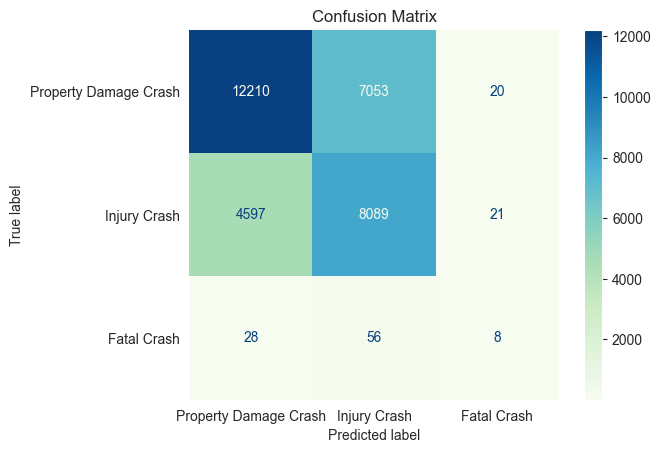

In [18]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Property Damage Crash', 'Injury Crash', 'Fatal Crash'])
disp.plot(cmap='GnBu', values_format='d')
sns.despine(left=True, bottom=True)
sns.set_style('dark')
plt.title("Confusion Matrix")
plt.show()

In [19]:
print(multi_eval(best_xgb_model, X_test, y_test, y_pred_xgb))

      Metric     Value
0   Accuracy  0.632972
1  Precision  0.647207
2     Recall  0.632972
3   F1-Score  0.636336
4    ROC-AUC  0.745693
